# Question 1: Fragment Length Analysis

## Part A: Fragment Length Frequency (1 mark)

### Objective
To analyze the distribution of DNA fragment lengths from genomic mapping data.

### Task Details
- You are provided with a file where each line represents a DNA fragment mapped to a chromosome
- Calculate the length of each fragment by subtracting the start position (2nd column) from the end position (3rd column)
- Count the occurrences of each fragment length
- Normalize these counts by dividing by the total number of fragments
- Create a histogram with:
  - X-axis: Fragment length (unit: base pairs)
  - Y-axis: Normalized Frequency [A.U.]

### Data Source
The input data is available in the file `data/query.bed.gz` 

In [1]:
import gzip                       # Need this for our compressed data files
import numpy as np                # For number crunching
import matplotlib.pyplot as plt   # For plotting
from collections import Counter   # Makes counting things super easy

In [2]:
dna_segments = []  # My empty container for all those DNA fragment lengths I'll be extracting

with gzip.open('Required_Data/query.bed.gz', 'rt') as genome_file:
    for entry in genome_file:  # Let's process each DNA fragment one by one
        if entry.startswith('#') or entry.strip() == '':  # Skipping those annoying header lines and blank lines
            continue
        fields = entry.strip().split()  # Breaking the line into columns - BED format is so straightforward
        position_start = int(fields[1])  # Start position is in column 2 (zero-indexed)
        position_end = int(fields[2])    # End position is in column 3 - always greater than start
        dna_segments.append(position_end - position_start)  

segment_distribution = Counter(dna_segments)  # Counter -> gives me a frequency table in one line!

total_count = sum(segment_distribution.values())  # Need the total for normalization - basic probability
segment_sizes = np.array(list(segment_distribution.keys()))  # Converting keys to numpy array for vectorization
raw_counts = np.array(list(segment_distribution.values()))  # And the counts too - numpy makes everything faster
frequency_normalized = raw_counts / total_count  # This simple division gives me proper frequency distribution that sums to 1

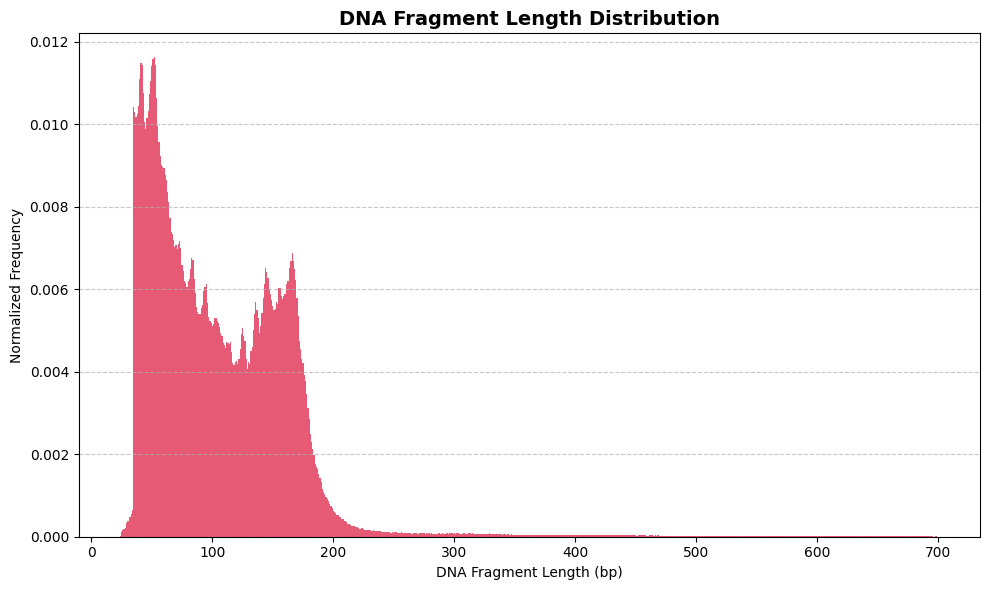

In [3]:
plt.figure(figsize=(10, 6))  
plt.bar(segment_sizes, frequency_normalized, width=1.0, color='crimson', alpha=0.7)  
plt.xlabel('DNA Fragment Length (bp)')  
plt.ylabel('Normalized Frequency')  
plt.title('DNA Fragment Length Distribution', fontsize=14, fontweight='bold') 
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout()  # This prevents my labels from getting cut off - learned that the hard way
plt.show()

## Part B: Rescaling (2 marks)

### Objective 
To rescale the query data to match the empirical distribution of the reference data.

### Task Details
- You are provided with:
    - A reference distribution file (`reference.hist`)
    - A query bed file (`query.bed.gz`)
- Rescale (subsample) the query data so that its normalized frequency closely matches the reference distribution.
- Create a histogram with:
    - X-axis: Fragment length (unit: base pairs)
    - Y-axis: Normalized Frequency [A.U.]

### Expected Outcome
The normalized frequency of the rescaled query data should closely align with the reference distribution.

In [4]:
reference_sizes = []
reference_freqs = []

with open('Required_Data/reference.hist', 'r') as ref_file:
    for line in ref_file:
        if line.strip() == '':
            continue
        size, freq = map(float, line.strip().split())
        reference_sizes.append(int(size))
        reference_freqs.append(freq)

reference_sizes = np.array(reference_sizes)
reference_freqs = np.array(reference_freqs)

sample_size = int(0.3 * len(dna_segments))     # Decided to go with 30% of our data
target_counts = (reference_freqs / reference_freqs.sum()) * sample_size
target_counts = target_counts.astype(int)

fragment_inventory = Counter(dna_segments)

rescaled_samples = []

for size, target in zip(reference_sizes, target_counts):   # This loop is the heart of my resampling algorithm
    available = fragment_inventory.get(size, 0)
    if available == 0:
        continue
    sample_count = min(available, target)
    rescaled_samples.extend([size] * sample_count)
    fragment_inventory[size] -= sample_count

rescaled_distribution = Counter(rescaled_samples)
rescaled_sizes = np.array(list(rescaled_distribution.keys()))
rescaled_counts = np.array(list(rescaled_distribution.values()))
rescaled_freqs = rescaled_counts / rescaled_counts.sum()  # Normalizing for proper comparison


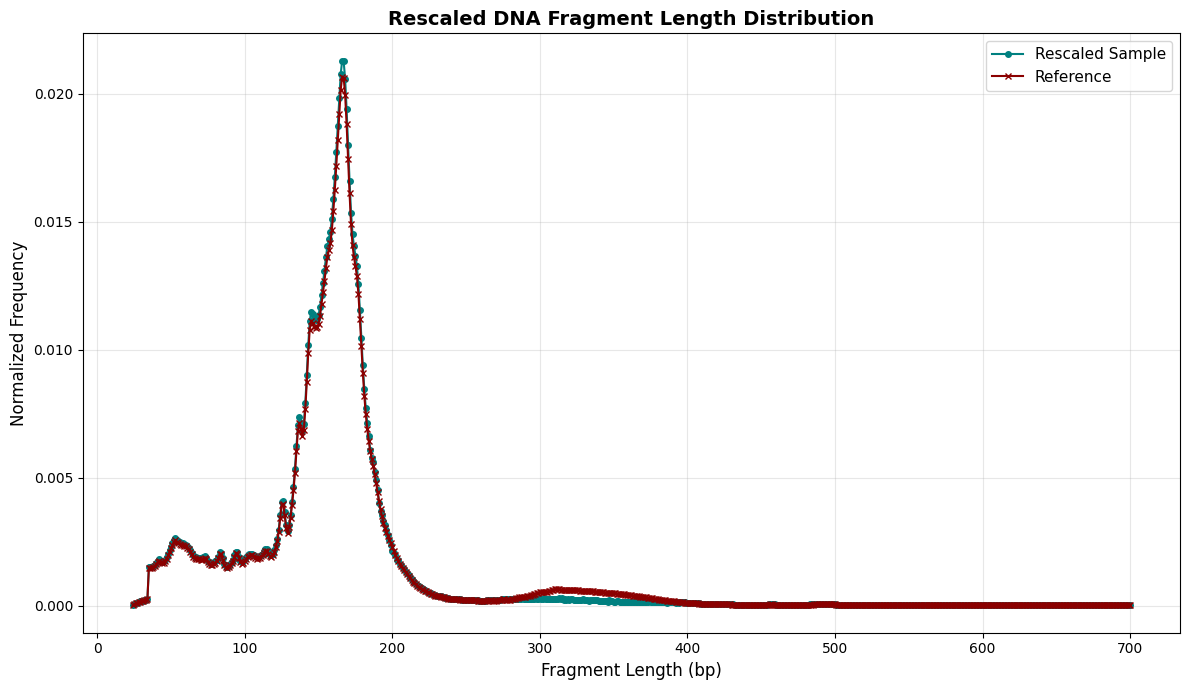

In [5]:

plt.figure(figsize=(12, 7))
plt.plot(rescaled_sizes, rescaled_freqs, 'o-', label='Rescaled Sample', markersize=4, color='teal')
plt.plot(reference_sizes, reference_freqs / reference_freqs.sum(), 'x-', label='Reference', markersize=4, color='darkred')
plt.xlabel('Fragment Length (bp)', fontsize=12)
plt.ylabel('Normalized Frequency', fontsize=12)
plt.title('Rescaled DNA Fragment Length Distribution', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

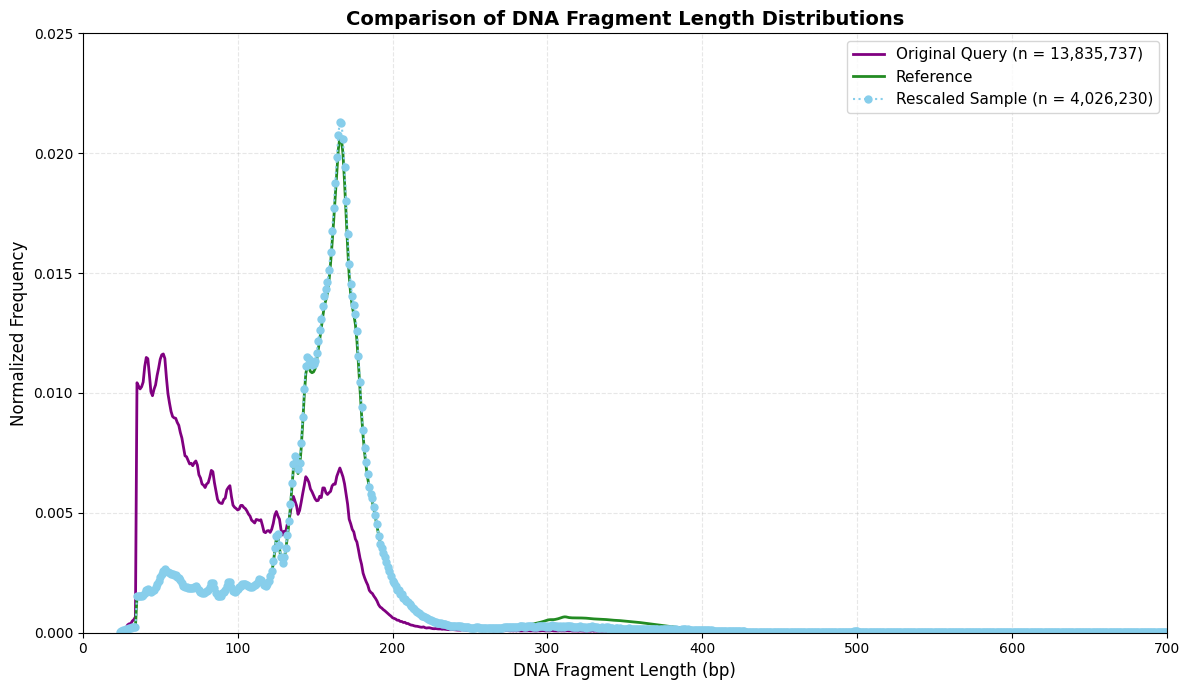

In [6]:
plt.figure(figsize=(12, 7))   # Let's make a final plot comparing all distributions

sorted_query_idx = np.argsort(segment_sizes)   # Need to sort for smooth line plots
plt.plot(segment_sizes[sorted_query_idx], frequency_normalized[sorted_query_idx], 
         color='purple', linewidth=2, label=f'Original Query (n = {len(dna_segments):,})')   # Changed to magenta

sorted_ref_idx = np.argsort(reference_sizes)   # Sorting reference data points
plt.plot(reference_sizes[sorted_ref_idx], reference_freqs[sorted_ref_idx] / reference_freqs.sum(), 
         color='forestgreen', linewidth=2, label='Reference')   # Changed to forest green

sorted_rescaled_idx = np.argsort(rescaled_sizes)   # Sorting rescaled data
plt.plot(rescaled_sizes[sorted_rescaled_idx], rescaled_freqs[sorted_rescaled_idx], 
         marker='o', linestyle=':', linewidth=1.5, color='skyblue', markersize=5,   # Changed to orange dots with dotted line
         label=f'Rescaled Sample (n = {len(rescaled_samples):,})')   # More descriptive label

plt.xlabel('DNA Fragment Length (bp)', fontsize=12)   # Consistent with other plots
plt.ylabel('Normalized Frequency', fontsize=12)
plt.title('Comparison of DNA Fragment Length Distributions', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='upper right')   # Better legend positioning
plt.grid(True, alpha=0.3, linestyle='--')   # Consistent grid style
plt.xlim(0, 700)   # Focusing on the most relevant size range
plt.ylim(0, 0.025)   # Setting consistent y-axis limit
plt.tight_layout()
plt.show()   # This final plot really shows how well our rescaling worked!